In [1]:
import sys
import os
import random
import argparse
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


In [2]:
## Define arguments
parser = argparse.ArgumentParser()
parser.add_argument('--nns', type=str)
# parser.add_argument('--run', type=int)
# parser.add_argument('--gpu', type=str)
parser.add_argument('--seed', type=int, default=42)
args = parser.parse_args(['--nns', 'cnn',  '--seed', '42'])
#you can use 'transformer', 'lstm', 'cnn' as nns


In [3]:
## Parameters setting    
# os.environ["CUDA_VISIBLE_DEVICES"]=args.gpu
seed = args.seed
np.random.seed(seed)
BATCH_SIZE = 128

In [4]:

def makeDataloader(path, batch_size):
    df = pd.read_pickle(path)
    # Extract features and label
    x1 = df['tcr_embeds']
    x2 = df['epi_embeds']
    label = df['binding']
  
    # Convert x1 and x2 to tensors
    x1_tensor = torch.tensor(x1.tolist())
    x2_tensor = torch.tensor(x2.tolist())
    x_tensor = torch.cat((x1_tensor, x2_tensor), 1)
    label_tensor = torch.tensor(label.tolist())
    # Create a TensorDataset with x_tensor
    dataset = TensorDataset(x_tensor,label_tensor)

    # Create the DataLoader
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    
    
    return dataloader

In [5]:

#Dataloader
# train
dataloader = makeDataloader('/home/mxx/ZZY/TCR_E/ours/our_Data/trainData_1024.pkl',BATCH_SIZE)
#test
test_dataloader = makeDataloader('/home/mxx/ZZY/TCR_E/ours/our_Data/testData_1024.pkl',BATCH_SIZE)


/tmp/ipykernel_154097/3564140736.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x1_tensor = torch.tensor(x1.tolist())


In [21]:

#Model


class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, num_classes=2):
        super(TransformerClassifier, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        out = self.classifier(x)
        return out
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)
        self.fc = None
        self.num_classes = num_classes

    def forward(self, x):
        x = x.unsqueeze(1)  # Add the channel dimension
        x = F.relu(self.conv1(x))
        if self.fc is None:
            # Initialize the fully connected layer based on the output size of the convolutional layer
            output_dim = x.view(x.size(0), -1).size(1)
            self.fc = nn.Linear(output_dim, self.num_classes).to(x.device)
        x = x.view(x.size(0), -1)  # Flatten the output
        out = self.fc(x)
        return out
    
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add the sequence dimension
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take the last output for classification
        out = self.fc(out)
        return out


In [30]:
# args.nns = 'transformer'# cnn lstm transformer

import logging
import datetime
# Get the current date and time
now = datetime.datetime.now()
# Format the date and time
now_str = now.strftime('%Y-%m-%d_%H-%M-%S')
# Remove all handlers for Jupyter
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Set up logging
log_path = '/home/mxx/ZZY/TCR_E/ours/log/'
log_file = f'{args.nns}_training_{now_str}.log'
logging.basicConfig(filename=os.path.join(log_path, log_file), level=logging.INFO, 
                    format='%(asctime)s %(levelname)s: %(message)s', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logging.info('Train and test loop log message') 
print(f'Log file created successfully.')


## Training
print('Start training...')
import torch.nn as nn
import torch.optim as optim
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
if args.nns == 'transformer':
    model = TransformerClassifier(input_dim = 2048, hidden_dim =512, num_layers =2, num_heads =4 , num_classes =2).to(device)
elif args.nns == 'cnn':
    model = CNNClassifier( num_classes =2).to(device)
elif args.nns == 'lstm':
    model = LSTMClassifier(input_dim = 2048, hidden_dim =512, num_layers =2, num_classes =2).to(device)
    
    
# Define the loss function, epoch and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10
#Initailize the best accuracy, train_losses and test_losses
best_acc = 0.0
train_losses = []
test_losses = []
best_recall = 0.0
best_F1 = 0.0


# Training and test loop
for epoch in range(num_epochs):
    # Training
    model.train()
    for x, label in dataloader:
        x, label = x.float().to(device),label.to(device)
        optimizer.zero_grad()
        output = model(x)
        acc = (output.argmax(dim=1) == label).float().mean()
        loss = criterion(output, label)
        loss.backward()
        TP = ((output.argmax(dim=1) == 1) & (label == 1)).float().sum()
        TP_FN = (label == 1).float().sum()
        recall = TP/TP_FN
        F1 = 2*acc*recall/(acc+recall)
        optimizer.step()
    train_losses.append(loss.item()) 
    logging.info(f'Epoch {epoch+1}/{num_epochs}, Train-Loss: {loss.item():.4f}, Train-Acc: {acc.item():.4f},Train-Recall: {recall.item():.4f} , Train-F1: {F1.item():.4f}')
    
    #Testing
    model.eval()
    with torch.no_grad():
        for x, label in test_dataloader:
            x, label = x.float().to(device), label.to(device)
            output = model(x)
            test_acc = (output.argmax(dim=1) == label).float().mean()
            test_loss = criterion(output, label)
            test_TP = ((output.argmax(dim=1) == 1) & (label == 1)).float().sum()
            test_TP_FN = (label == 1).float().sum()
            test_recall = test_TP/test_TP_FN
            test_F1 = 2*test_acc*test_recall/(test_acc+test_recall)
    test_losses.append(test_loss.item())
    logging.info(f'Epoch {epoch+1}/{num_epochs}, Test-Loss: {test_loss.item():.4f}, Test-Acc: {test_acc.item():.4f},Test-Recall: {test_recall.item():.4f} , Test-F1: {test_F1.item():.4f}')
    
    #Save model
    if test_acc > best_acc:
        best_acc = test_acc
        best_recall = test_recall
        best_F1 = test_F1
        model_dir = '/home/mxx/ZZY/TCR_E/ours/model/'+args.nns
        os.makedirs(model_dir, exist_ok=True)  # Create the directory if it does not exist
        torch.save(model.state_dict(), os.path.join(model_dir, '_best_model.pth'))
        logging.info(f'Best model saved at epoch {epoch+1}, acc: {best_acc.item():.4f}')

logging.info(f'Best test accuracy: {best_acc.item():.4f}, Best test recall: {best_recall.item():.4f}, Best test F1: {best_F1.item():.4f}')
    

Log file created successfully.
Start training...


/home/mxx/anaconda3/envs/myenv2/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


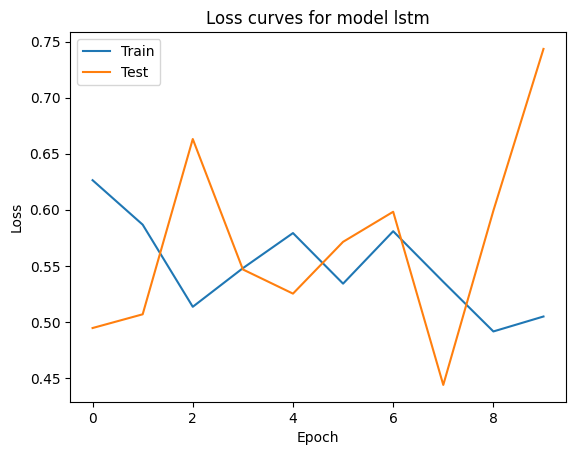

In [10]:
# Plot the losses
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Train')
plt.plot(range(num_epochs), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves for model ' + args.nns)  # Add title
plt.legend()
#Save
log_dir = '/home/mxx/ZZY/TCR_E/ours/log'
os.makedirs(log_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(os.path.join(log_dir, f'loss_curves_{args.nns}.png'))

plt.show()